<a href="https://colab.research.google.com/github/AmyMorrison2/Capstone/blob/main/Copy_of_CAPSTONE_DELIVERABLE_MORRISON_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Milestone--Data Acquisition

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
from sklearn.preprocessing import StandardScaler


# define index names: ^GSPC = S&P 500, ^DJI = DOW Jones, ^IXIC=NASDAQ 100, ^RUT = Russell 2000
index_names = ['^GSPC', '^DJI', '^IXIC', '^RUT']

# define date range (2018-2023 to examine trends across 6 year-period which contains the time frame of the crash)
start_date_string = "2018-01-01"
end_date_string = "2023-12-31"

# pull data from Yahoo Finance
raw_data = yf.download(index_names, start=start_date_string, end=end_date_string)

[*********************100%%**********************]  4 of 4 completed


In [ ]:
# Milestone--EDA

# keep only adjusted closing prices
df_close = raw_data['Adj Close'].dropna(axis='rows')

# examine new dataset
df_close

Ticker,^DJI,^GSPC,^IXIC,^RUT
Date,,,,
2018-01-02,24824.009766,2695.810059,7006.899902,1550.010010
2018-01-03,24922.679688,2713.060059,7065.529785,1552.579956
2018-01-04,25075.130859,2723.989990,7077.910156,1555.719971
2018-01-05,25295.869141,2743.149902,7136.560059,1560.010010
2018-01-08,25283.000000,2747.709961,7157.390137,1561.810059
...,...,...,...,...
2023-12-22,37385.968750,4754.629883,14992.969727,2033.959961
2023-12-26,37545.328125,4774.750000,15074.570312,2059.189941
2023-12-27,37656.519531,4781.580078,15099.179688,2066.209961


In [ ]:
!pip install numpy pandas torch sklearn


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

train_data = df_close['2018-01-02':'2020-03-08']
test_data = df_close['2020-03-09':'2020-06-30']

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# convert scaled data to PyTorch tensors
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

seq_length = 5  # Number of past days to consider for prediction
train_sequences = create_inout_sequences(train_scaled, seq_length)
test_sequences = create_inout_sequences(test_scaled, seq_length)

# Creating dataloaders
train_dataset = TensorDataset(torch.tensor([s[0] for s in train_sequences]).float(),
                              torch.tensor([s[1] for s in train_sequences]).float())
test_dataset = TensorDataset(torch.tensor([s[0] for s in test_sequences]).float(),
                             torch.tensor([s[1] for s in test_sequences]).float())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)



<ipython-input-4-5eff7d5b4b36>:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  train_dataset = TensorDataset(torch.tensor([s[0] for s in train_sequences]).float(),


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel(input_dim=4, hidden_dim=100, num_layers=2, output_dim=4)
loss_function = nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


In [ ]:
def train_model(model, train_loader, loss_function, optimizer, epochs):
    for epoch in range(epochs):
        for seq, labels in train_loader:
            optimizer.zero_grad()
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels.squeeze(1))
            single_loss.backward()
            optimizer.step()

        if epoch%25 == 0:
            print(f'Epoch {epoch} loss: {single_loss.item()}')

num_epochs = 100
train_model(model, train_loader, loss_function, optimizer, num_epochs)


Epoch 0 loss: 1.2112311124801636
Epoch 25 loss: 0.07991927862167358
Epoch 50 loss: 0.040166787803173065
Epoch 75 loss: 0.02268318459391594


Decreasing loss during epochs indicates the model is learning during the training phase.

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for seq, labels in test_loader:
            y_pred = model(seq)
            predictions.append(y_pred.numpy())
            actuals.append(labels.numpy())

    return predictions, actuals

predictions, actuals = evaluate_model(model, test_loader)


In [ ]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def compute_metrics(model, loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for seq, labels in loader:
            y_pred = model(seq)

            predictions.append(y_pred.view(-1, y_pred.shape[-1]).cpu().numpy())
            actuals.append(labels.view(-1, labels.shape[-1]).cpu().numpy())

    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)
    mse = mean_squared_error(actuals, predictions)
    return mse, predictions, actuals

train_mse, train_predictions, train_actuals = compute_metrics(model, train_loader)
test_mse, test_predictions, test_actuals = compute_metrics(model, test_loader)

index_names = ['^DJI','^GSPC','^IXIC', '^RUT']
dates = pd.to_datetime(df_close.index).to_numpy()

train_dates = dates[:len(train_actuals)]
test_dates = dates[len(train_actuals):len(train_actuals) + len(test_actuals)]

In [ ]:
from sklearn.preprocessing import StandardScaler

train_actuals_unscaled = scaler.inverse_transform(train_actuals)
train_predictions_unscaled = scaler.inverse_transform(train_predictions)
test_actuals_unscaled = scaler.inverse_transform(test_actuals)
test_predictions_unscaled = scaler.inverse_transform(test_predictions)


In [ ]:
df_close.index = pd.to_datetime(df_close.index)

dates = df_close.index.to_numpy()

train_dates = dates[:len(train_actuals)]
test_dates = dates[len(train_actuals):len(train_actuals) + len(test_actuals)]

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics_per_index(actuals, predictions, index_names):
    results = {}
    for i, name in enumerate(index_names):
        index_actuals = actuals[:, i]
        index_predictions = predictions[:, i]

        mse = mean_squared_error(index_actuals, index_predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(index_actuals, index_predictions)
        mape = np.mean(np.abs((index_actuals - index_predictions) / index_actuals)) * 100
        r2 = r2_score(index_actuals, index_predictions)

        results[name] = {
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "MAPE": mape,
            "R²": r2
        }
    return results

train_results = calculate_metrics_per_index(train_actuals, train_predictions, index_names)
test_results = calculate_metrics_per_index(test_actuals, test_predictions, index_names)

print("Training Metrics by Index:")
for index, metrics in train_results.items():
    print(f"{index}: {metrics}")

print("\nTesting Metrics by Index:")
for index, metrics in test_results.items():
    print(f"{index}: {metrics}")

Training Metrics by Index:
^DJI: {'MSE': 0.039913565, 'RMSE': 0.1997838, 'MAE': 0.14233173, 'MAPE': 123.27286005020142, 'R²': 0.9603374890521488}
^GSPC: {'MSE': 0.025889797, 'RMSE': 0.16090307, 'MAE': 0.11556531, 'MAPE': 58.868372440338135, 'R²': 0.9741455955597975}
^IXIC: {'MSE': 0.02490744, 'RMSE': 0.15782091, 'MAE': 0.11531531, 'MAPE': 62.806910276412964, 'R²': 0.9748818792252006}
^RUT: {'MSE': 0.049651206, 'RMSE': 0.2228255, 'MAE': 0.16562733, 'MAPE': 98.4332799911499, 'R²': 0.950835498855375}

Testing Metrics by Index:
^DJI: {'MSE': 0.41437158, 'RMSE': 0.643717, 'MAE': 0.44034654, 'MAPE': 42.82834231853485, 'R²': 0.7906208318314637}
^GSPC: {'MSE': 0.19297948, 'RMSE': 0.4392943, 'MAE': 0.32703078, 'MAPE': 215.90371131896973, 'R²': 0.8749652248035973}
^IXIC: {'MSE': 1.2562463, 'RMSE': 1.120824, 'MAE': 1.0697212, 'MAPE': 246.44498825073242, 'R²': 0.3927005049409106}
^RUT: {'MSE': 1.2355281, 'RMSE': 1.1115432, 'MAE': 0.885236, 'MAPE': 24.125009775161743, 'R²': 0.5601230578831207}


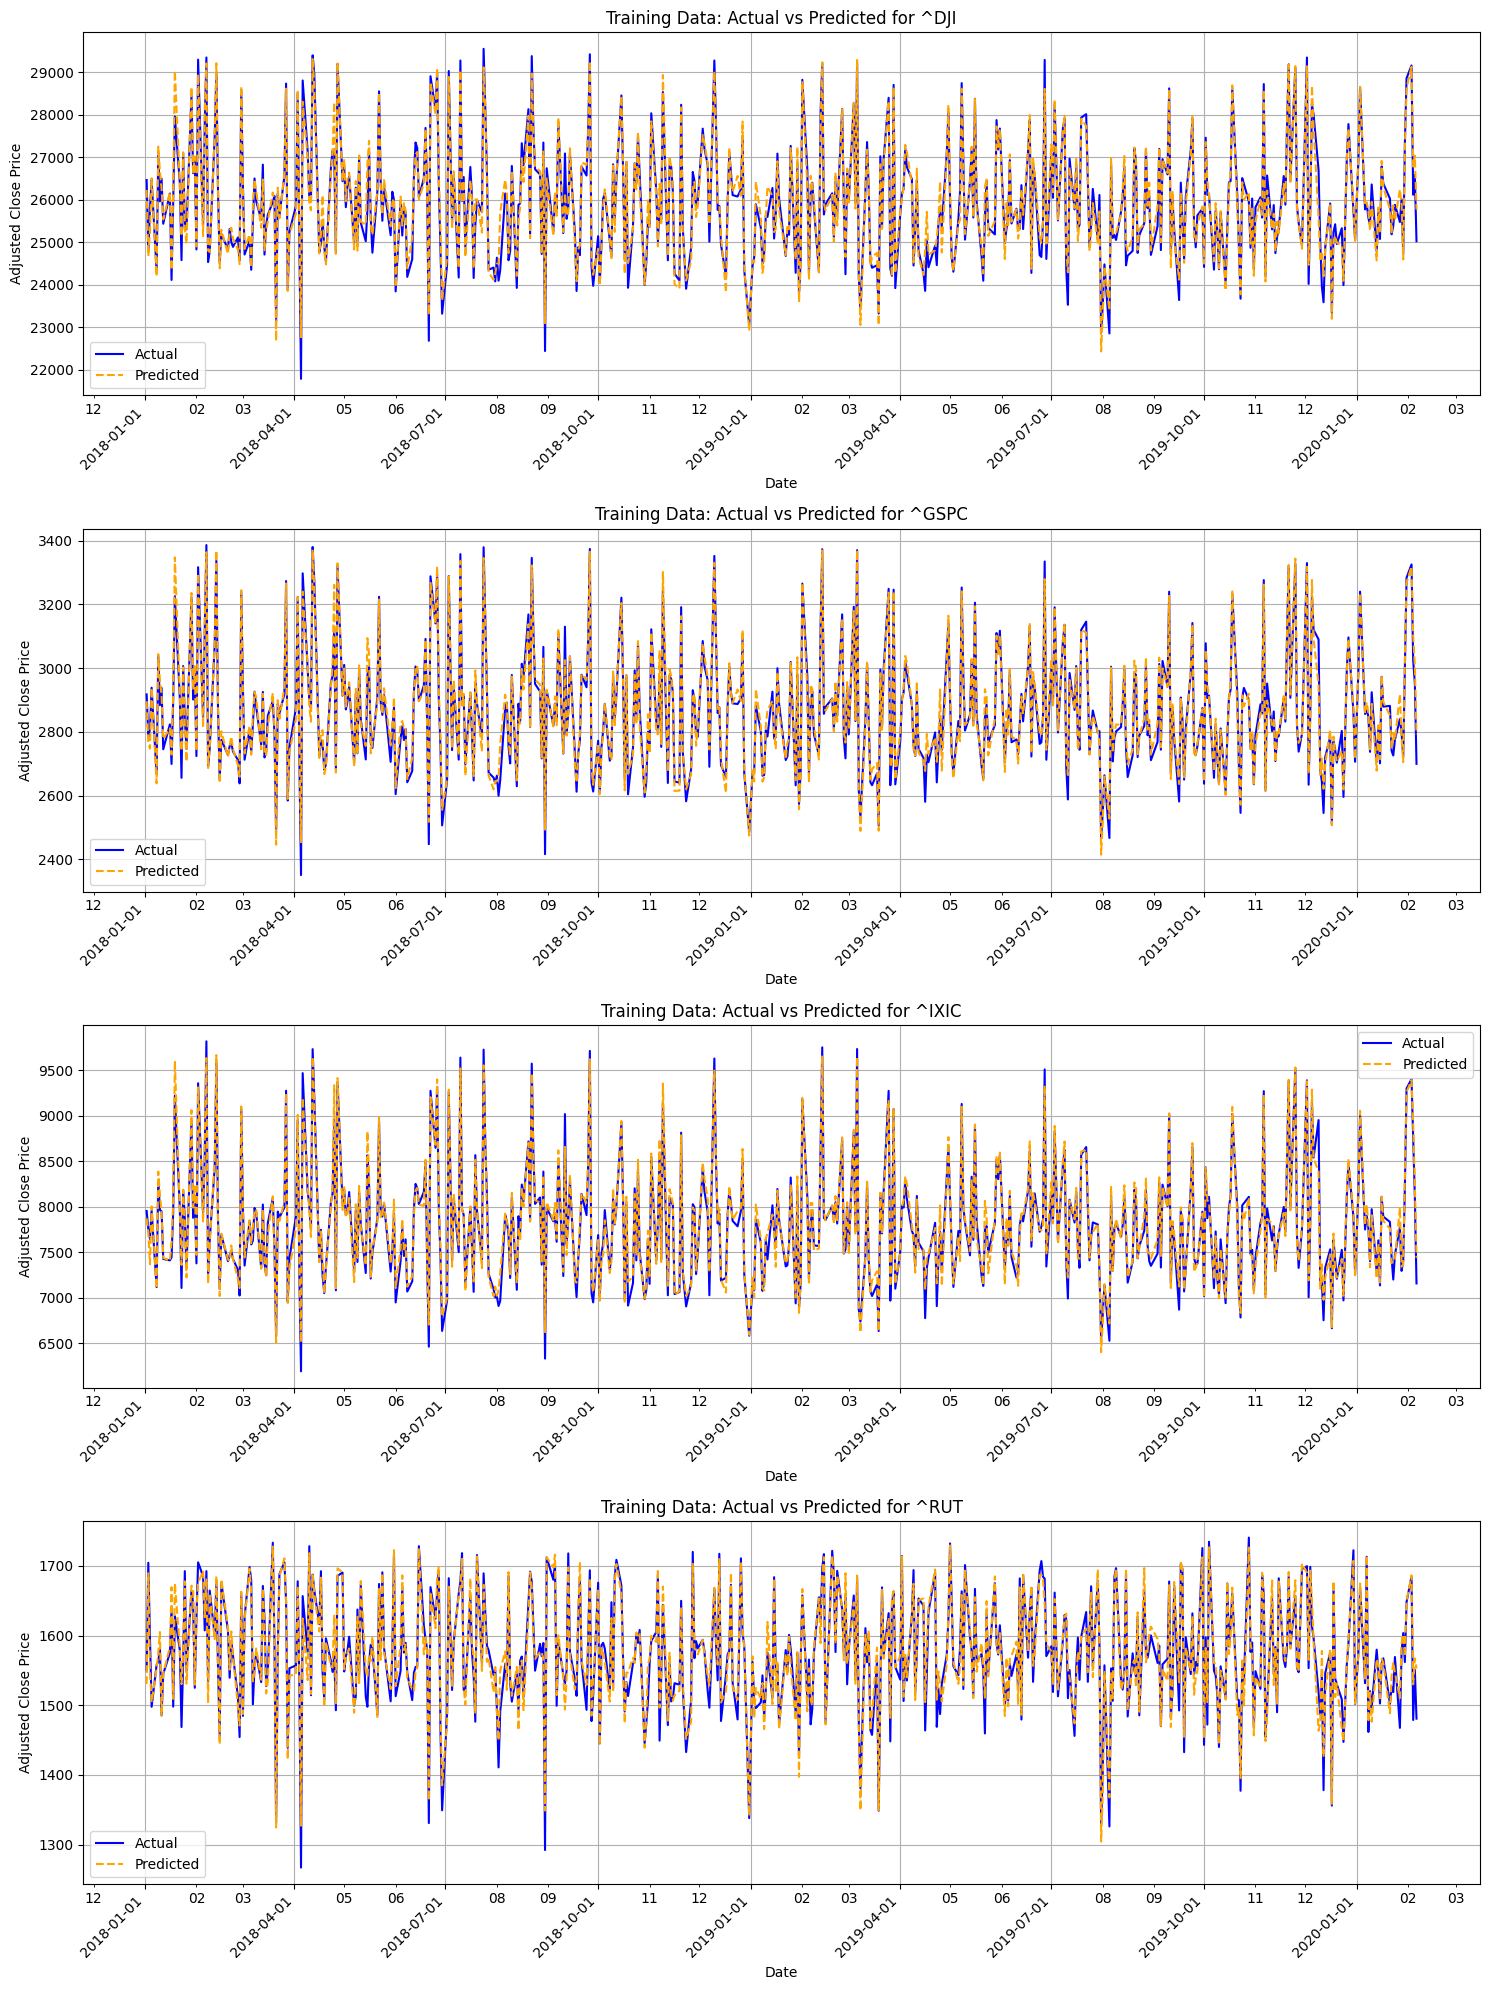

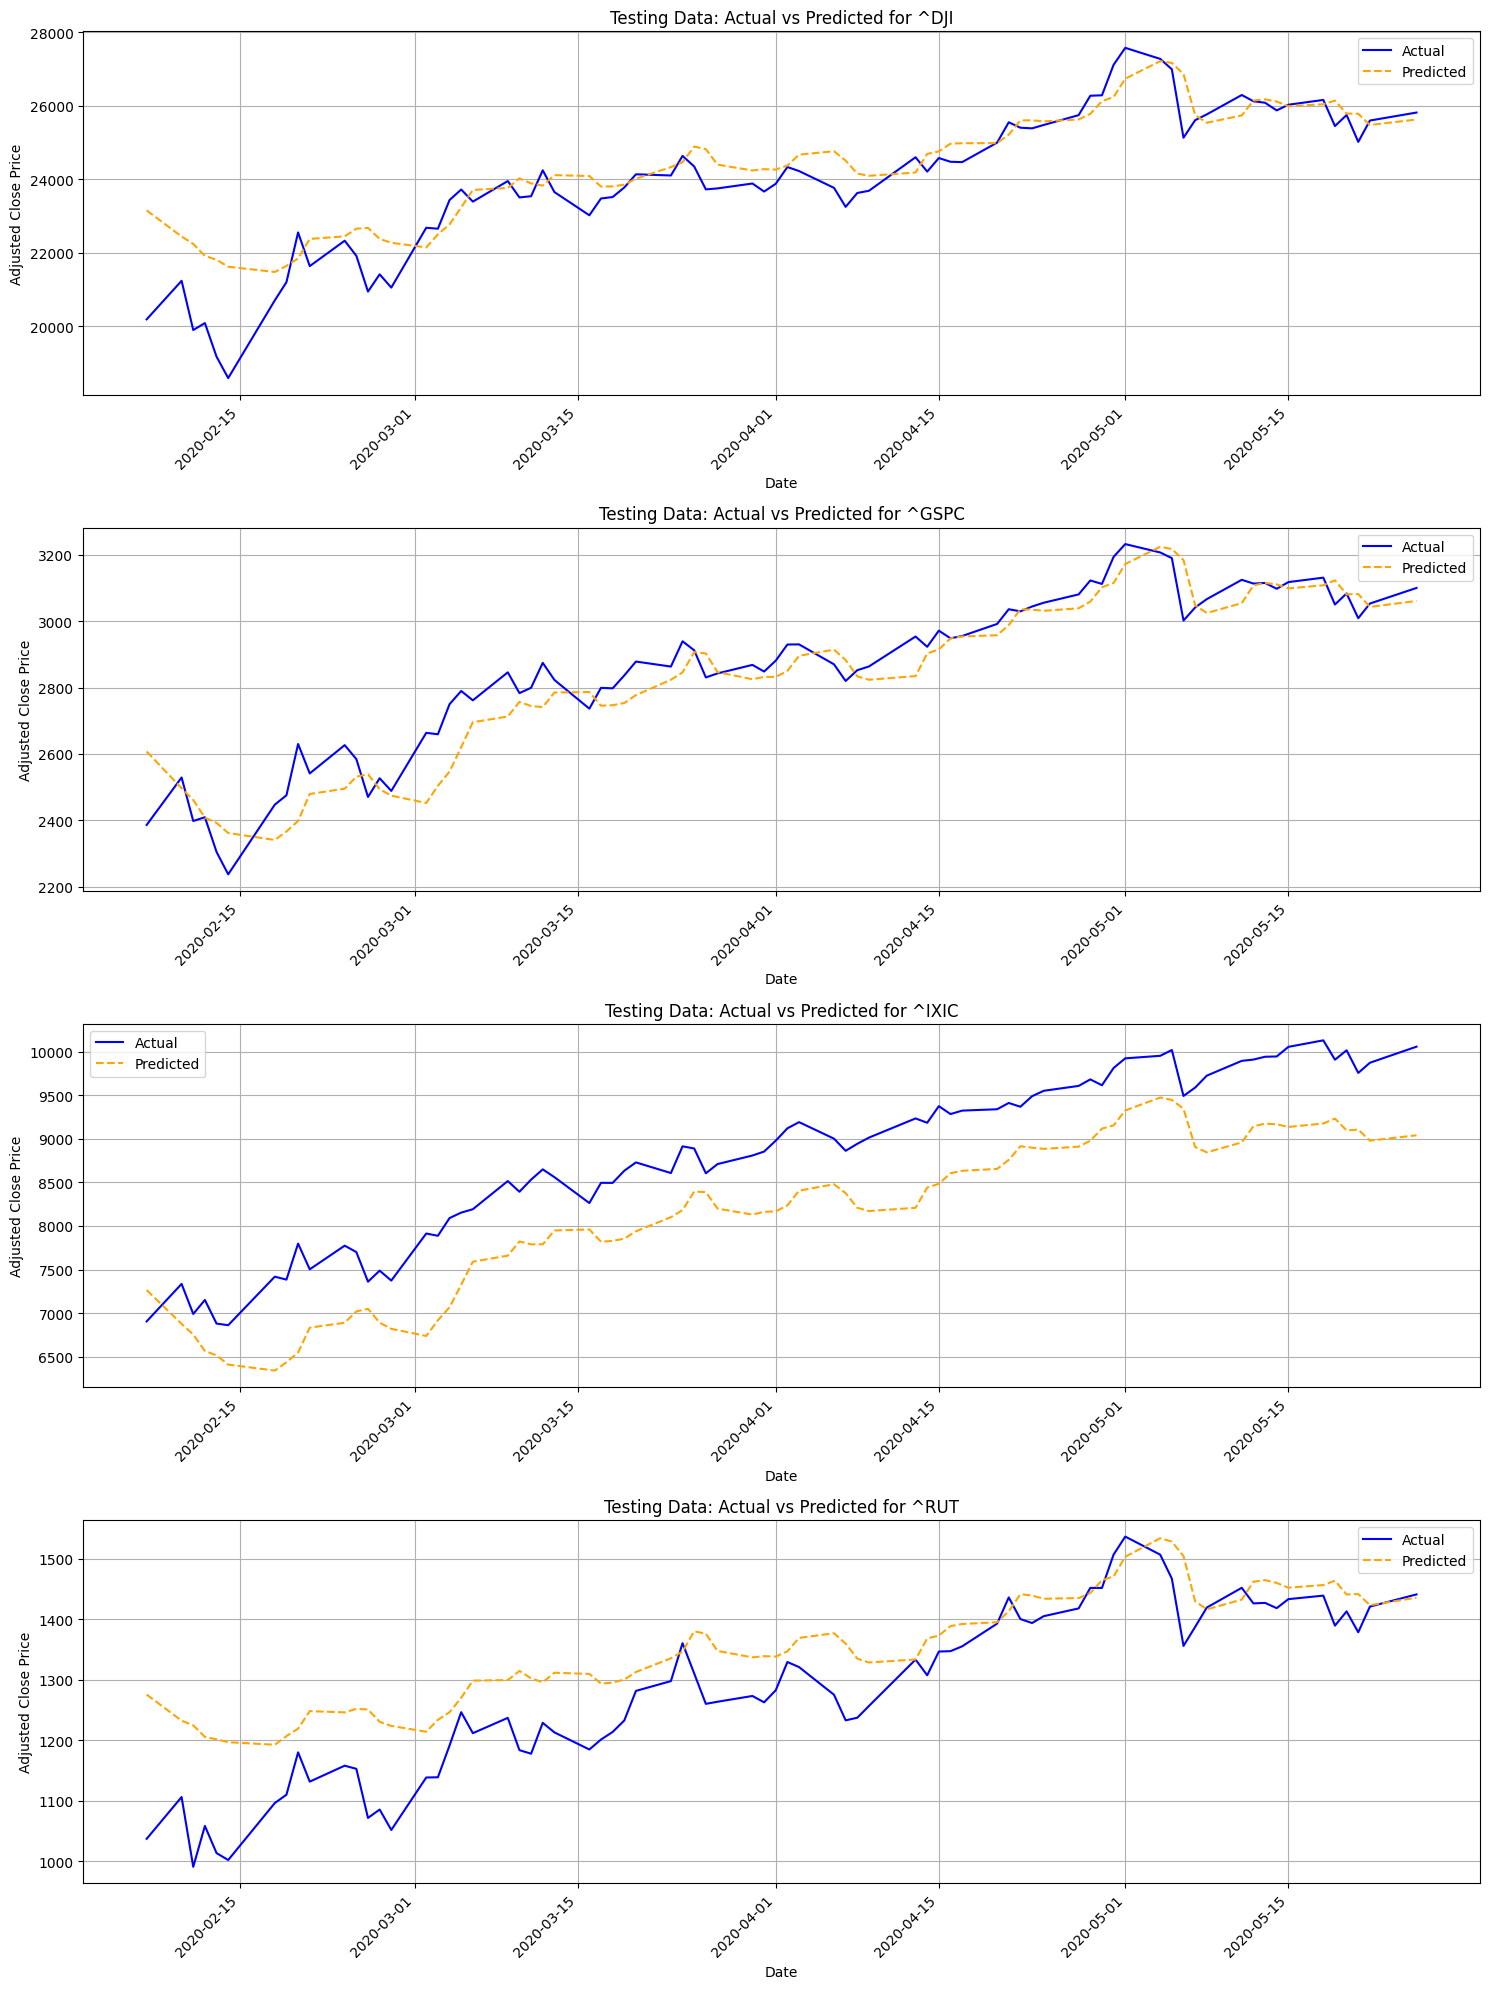

In [ ]:
def plot_results_individual(actuals, predictions, title, index_names, dates):
    num_indices = actuals.shape[1]
    fig, axes = plt.subplots(num_indices, 1, figsize=(15, 5 * num_indices), sharex=False)  # Set sharex to False

    if num_indices == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        ax.plot(dates, actuals[:, i], label='Actual', color='blue')
        ax.plot(dates, predictions[:, i], label='Predicted', linestyle='--', color='orange')
        ax.set_title(f'{title} for {index_names[i]}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Adjusted Close Price')
        ax.legend()
        ax.grid(True)


        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))

        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

        ax.xaxis.set_tick_params(which='both', labelbottom=True)

    plt.tight_layout()
    plt.show()
plot_results_individual(train_actuals_unscaled, train_predictions_unscaled, "Training Data: Actual vs Predicted", index_names, train_dates)
plot_results_individual(test_actuals_unscaled, test_predictions_unscaled, "Testing Data: Actual vs Predicted", index_names, test_dates)


**Comments on LSTM Performance**

Initially attempted adam optimizer. This resulted in relatively significant overfitting. Increasing hidden dimensions and layers worsened performance as the complexity increased. Then attempted SGD optimizer in order to reduce overfitting. Training data R^2 went from minimum of .99 to .95 for all indices; however, performance for testing data improved.

The performance of a stacked RNN LSTM model predicting adjusted closing prices for four stock indices showed distinct variations between training and testing. In training, the model demonstrated high accuracy with R^2 values above 0.95 for all indices. This suggested a strong fit to the data.

The performance of the stacked RNN LSTM model varied significantly across the four stock indices when using the SGD optimizer. For the ^DJI, the model showed decent generalization with an R² of approximately 0.79 on unseen data, indicating a reasonable prediction accuracy. The ^GSPC, although it had the highest R² of 0.875, suffered from very high relative errors, as shown by its MAPE of over 215%, suggesting occasional large prediction errors. The ^IXIC index exhibited poor performance with an R² of only 0.39, reflecting significant challenges in accurately forecasting this index. Lastly, the ^RUT index showed moderate generalization with an R² of 0.56, and despite having the lowest MAPE among the indices, it still indicated a substantial discrepancy in prediction accuracy across different market conditions. Overall, each index revealed unique challenges and degrees of success in the model's ability to predict their movements perfectly.